# Table of contents
1. [Introduction](#introduction)
2. [Specify data transforms](#transforms)
3. [Load the dataset](#load)
4. [Perform classifications](#train)
5. [Evaluate with Grad-CAM](#eval)
6. [Evaluate train metrics](#trainmetrics)

## Introduction <a name="introduction"></a>

This notebook loads the plant dataset consisting of 452 healthy and 452 stressed images from disk and trains a resnet50 classifier on it. Training metrics from the original run are loaded from disk and plots to visualize its performance are created.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import matplotlib.pyplot as plt
import time
import os
import copy
import random

## Specify data transforms <a name="transforms"></a>

Before we load the dataset, we define two types of data transforms. One is for the training and one for the validation set. The training set is augmented with a random resized crop to the image size the resnet50 model expects and is also sometimes flipped horizontally. The image is then transformed into a tensor and normalized with the ImageNet mean and standard deviation for each channel.

The validation set should not contain horizontally flipped or randomly cropped images and so the images are only resized and cropped to fit the model's exptected inputs. Normalization still has to happen.

In [2]:
cudnn.benchmark = True
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Load the dataset <a name="load"></a>

The directory `plantsdata` contains two folders named `healthy` and `wilted`. This folder is loaded into an `ImageFolder` class and then split with `random_split()` into a 90/10 train/val split. The respective transforms are added to the two datasets and loaders are created.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

data_dir = 'plantsdata'
dataset = datasets.ImageFolder(os.path.join(data_dir))

# 90/10 split
train_dataset, val_dataset = random_split(dataset, [0.9, 0.1])

dataset_size = len(dataset)

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                           shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=True, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

class_names = dataset.classes

num_epochs = 50
batch_size = 4

## Perform classifications <a name="train"></a>

This function takes a model, a loss function (`criterion`), an optimizer (SGD in this case) and a scheduler which lowers the learning rate every 7 epochs to aid in finding minima. All of these parameters can be customized to use a different loss function, optimizer, and so on. Training commences for `num_epochs` and the epoch with the best validation accuracy is always saved. As soon as training is finished, the model with the best validation accuracy is returned.

Metrics during training (`train_acc`, `train_loss`, `val_acc`, `val_loss`) are saved to a dictionary called `history`. This dictionary has to be initialized beforehand with empty lists for each of the four metrics.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Here we create the empty history dictionary, load the pre-trained resnet from `pytorch.models` and add a linear layer with the amount of classes we have (2). The loss function is set to `CrossEntropyLoss()` and the optimizer is SGD with a learning rate of 0.001. The scheduler decays the learning rate every 7 steps by 0.1.

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc':[]}
model_ft = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Add linear layer with number of classes
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Some metrics in the `history` dict are still tensors and associated with the GPU. This will create a second dictionary `history_new` which only contains the scalar values.

In [63]:
history_new = {'train_loss': history['train_loss'].copy(),
               'val_loss': history['val_loss'].copy(),
               'train_acc': [],
               'val_acc': []}
for key in ['train_acc', 'val_acc']:
    for elem in history[key]:
        history_new[key].append(elem.detach().cpu().item())

In [ ]:
df = pd.DataFrame(history_new)
df

## Evaluate with Grad-CAM <a name="eval"></a>

In this section we load the originally trained model (the one which has been trained earlier and tested on the Jetson Nano) and do inference on a test image which contains a healthy and stressed plant not seen before.

In [6]:
#### visualize_model(model_ft)
#model_ft.eval()
#torch.save(model_ft, "resnet-model-latest.pt")
model_ft = torch.load("resnet-model.pt")

In [7]:
import PIL

We load the image, transform it with the same normalization as before, do inference and run the result through a softmax layer to get probabilities for each class. Our test image is classified as 30% healthy and 70% stressed.

In [10]:
model_ft.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
img = PIL.Image.open("/home/zenon/test.jpg")
rgb_img = np.array(PIL.Image.open("/home/zenon/test.jpg"))
rgb_img = rgb_img.astype(np.float32)
rgb_img /= 255

data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

img = data_transforms(img)

device = "cpu"

#if "cuda" in str(device) and not torch.cuda.is_available():
#    device = "cpu"

img = img.to(device)
model_ft.to(device)
out = model_ft(img.unsqueeze(0))
torch.nn.functional.softmax(out, dim=1)[0] * 100


tensor([29.4928, 70.5072], grad_fn=<MulBackward0>)

We can then use the image and the prediction with Grad-CAM to evaluate which regions contributed most to either class. The CAM object is created and the target layers for resnet is the last convolutional layer. In `targets` we specify which class we want to generate CAMs for; 0 means healthy and 1 means stressed. The visualization image is then stored in a variable so that we can plot it later.

In [47]:
from pytorch_grad_cam import *
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [model_ft.layer4[-1]]
input_tensor = img.unsqueeze(0)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_ft, target_layers=target_layers)

# Specify target for CAM (0 = healthy, 1 = stressed)
targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
rgb_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

# In this example rgb_cam has only one image in the batch:
rgb_cam = rgb_cam[0, :]
visualization_healthy = show_cam_on_image(rgb_img, rgb_cam, use_rgb=True)

# Specify target for CAM (0 = healthy, 1 = stressed)
targets = [ClassifierOutputTarget(1)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
rgb_cam = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True)

rgb_cam = rgb_cam[0, :]
visualization_stressed = show_cam_on_image(rgb_img, rgb_cam, use_rgb=True)

In [44]:
from evaluation.helpers import set_size
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [45]:
# Style the plots
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8,
                  'axes.grid': False})

fig_save_dir = '../../thesis/graphics/'

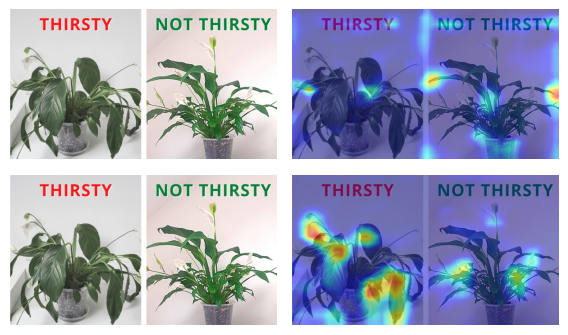

In [55]:
fig, ax = plt.subplots(2, 2, figsize=set_size(width, subplots=(2,2)))
ax[0][0].imshow(rgb_img)
ax[0][1].imshow(visualization_healthy)
ax[1][0].imshow(rgb_img)
ax[1][1].imshow(visualization_stressed)
# Omit pixel values for the axis
ax[0][0].axis('off')
ax[0][1].axis('off') 
ax[1][0].axis('off') 
ax[1][1].axis('off') 
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-cam.pdf', format='pdf', bbox_inches='tight')

## Evaluate train metrics <a name="trainmetrics"></a>

We define the style of the plots with a grid this time and specify the directory to save images to. Metrics from the original run are loaded from the csv file and accuracy during training and validation is plotted. The second plot visualizes the loss during training for the train and validation set.

In [57]:
# Style the plots (with grid this time)
width = 418
sns.set_theme(style='whitegrid',
              rc={'text.usetex': True, 'font.family': 'serif', 'axes.labelsize': 10,
                  'font.size': 10, 'legend.fontsize': 8,
                  'xtick.labelsize': 8, 'ytick.labelsize': 8})

fig_save_dir = '../../thesis/graphics/'

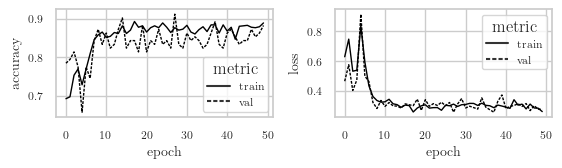

In [58]:
results = pd.read_csv('train-metrics.csv')
accs = results[['epoch', 'train_acc', 'val_acc']].rename(columns={'train_acc': 'train', 'val_acc': 'val'}).melt('epoch', var_name='metric', value_name='vals')
loss = results[['epoch', 'train_loss', 'val_loss']].rename(columns={'train_loss': 'train', 'val_loss': 'val'}).melt('epoch', var_name='metric', value_name='vals')

fig, ax = plt.subplots(1, 2, figsize=set_size(width, subplots=(1,2)))
sns.lineplot(data=loss, x='epoch', y='vals', color='black',
             style='metric', dashes=["", (2,1)],
             ax=ax[1], linewidth=1)
sns.lineplot(data=accs, x='epoch', y='vals', color='black',
             style='metric', dashes=["", (2,1)],
             ax=ax[0], linewidth=1)
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('loss')
fig.tight_layout()
fig.savefig(fig_save_dir + 'classifier-metrics.pdf', format='pdf', bbox_inches='tight')